**Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

**Code**

In [2]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)  # GRU forward pass
        out = self.fc(out[:, -1, :])  # Output from the last time step
        return out

In [4]:
# Hyperparameters
input_size = 28       # Number of features in each sequence step (MNIST row size)
sequence_length = 28  # Number of time steps (MNIST column size)
hidden_size = 128     # Hidden state size
num_layers = 2        # Number of GRU layers
num_classes = 10      # Number of output classes (digits 0-9)
batch_size = 64       # Batch size for training
learning_rate = 0.001 # Learning rate for optimizer
num_epochs = 5        # Number of epochs to train

In [5]:
# Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss Function, Optimizer
model = GRUModel(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, num_layers=num_layers, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Training
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.view(-1, sequence_length, input_size).to(device)  # Reshape images
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimization step

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = (correct / total) * 100
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.2f}, Accuracy: {accuracy:.2f}%")

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch [1/5], Loss: 0.36, Accuracy: 88.08%
Epoch [2/5], Loss: 0.09, Accuracy: 97.36%
Epoch [3/5], Loss: 0.06, Accuracy: 98.23%
Epoch [4/5], Loss: 0.05, Accuracy: 98.62%
Epoch [5/5], Loss: 0.04, Accuracy: 98.87%


In [7]:
# Testing function
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = (correct / total) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_predictions

# Test the model
all_labels, all_predictions = test_model(model, test_loader, device)

Test Accuracy: 98.73%


In [8]:
# Print sample labels and predictions
print("Sample True Labels:", all_labels[:10])
print("Sample Predictions:", all_predictions[:10])

Sample True Labels: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
Sample Predictions: [7, 2, 1, 0, 4, 1, 4, 9, 8, 9]


In [9]:
# Save the model
torch.save(model.state_dict(), 'mnist_gru_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [10]:
# Reload the model for testing
loaded_gru_model = GRUModel(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, num_layers=num_layers, dropout=0.3).to(device)
loaded_gru_model.load_state_dict(torch.load('mnist_gru_model.pth'))
loaded_gru_model.eval()
print("Model loaded successfully.")

Model loaded successfully.


<ipython-input-10-e7c5cb71e546>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_gru_model.load_state_dict(torch.load('mnist_gru_model.pth'))


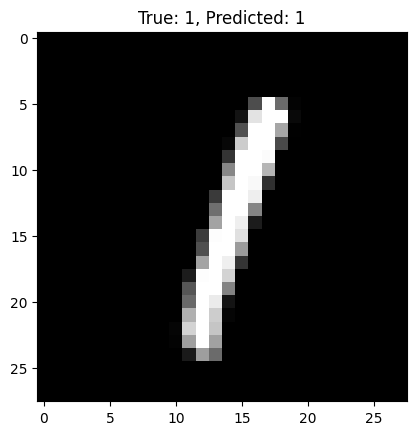

In [11]:
# Visualize a sample image and its prediction
def visualize_sample(model, dataset, idx):
    model.eval()
    sample_image, sample_label = dataset[idx]
    sample_image = sample_image.unsqueeze(0).to(device)
    output = model(sample_image.view(-1, sequence_length, input_size))
    _, predicted_label = torch.max(output, 1)

    plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
    plt.title(f"True: {sample_label}, Predicted: {predicted_label.item()}")
    plt.show()

# Visualize a test sample
visualize_sample(loaded_gru_model, test_dataset, idx=5)  # Change idx for different samples